<a href="https://colab.research.google.com/github/Sergirsanchez/AI-CDT/blob/master/final_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CODE THAT WILL GO ON OTHER FILE**

**This file will be to store the functions and parameters, in order to have the files cleaner**

*Needed imports*

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils
from keras.callbacks import LearningRateScheduler
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
import time
import json
import math
import string
from contextlib import redirect_stdout

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

*Function to plot the confusion matrices*

In [ ]:
def plot_confusion_matrix(cm,target_names, title='Confusion matrix', cmap=None, normalize=True, store = False):
  '''Function given by ScikitLearn with a couple of changes on figure size to display a confusion matrix.
    
  Parameters
  ----------
  cm : estimator instance
      Fitted classifier or a fitted Pipeline in which the last estimator is a classifier.
      
  target_names : array-like of shape (n_samples,)
      Target values.
      
  title: str, optional
      Title of the confusion matrix
      
  cmpa: str or matplotlib Colormap, optional
      Colormap recognized by matplotlib.
      
  normalize: {‘true’, ‘pred’, ‘all’}, optional
      Normalizes confusion matrix over the true (rows), predicted (columns) conditions or all the population. If None, confusion matrix will not be normalized.
      
  store: boolean, optional
    if True stores the cm. Otherwise, just show it
    
  Returns
  -------
  plt
      Confusion matrix, just if "Store" was set to true
  '''
  FONT_SIZE = 8

  accuracy = np.trace(cm) / float(np.sum(cm))
  misclass = 1 - accuracy

  if cmap is None:
      cmap = plt.get_cmap('Blues')

  plt.figure(figsize=(4*2, 3*2))    # 8, 6
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()

  if target_names is not None:
      tick_marks = np.arange(len(target_names))
      plt.xticks(tick_marks, target_names, rotation=90, fontsize=FONT_SIZE)
      plt.yticks(tick_marks, target_names, fontsize=FONT_SIZE)

  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


  thresh = cm.max() / 1.5 if normalize else cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      if normalize:
          plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                    horizontalalignment="center",
                    fontsize=FONT_SIZE,
                    color="white" if cm[i, j] > thresh else "black")
      else:
          plt.text(j, i, "{:,}".format(cm[i, j]),
                    horizontalalignment="center",
                    fontsize=FONT_SIZE,
                    color="white" if cm[i, j] > thresh else "black")


  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  
  if store:
      return plt
  else:
      plt.show()

*Function to create the necessary folders to start the image preprocessing*

In [ ]:
def fold_validation(origin_path, augment_passed, augment_failed , folder_name, number_augmented_passed=0, number_augmented_failed=0,  number_of_folds = 5, batch_size=10 , zoom_percentage = 5,
                    save_format = 'png', save_prefix = 'augmented', model=tf.keras.applications.vgg16.VGG16(), optimizer=Adam(learning_rate=0.001), optimizer_options = {'learning_rate':0.001}, 
                    use_stepLR=False, stepLR_values={'drop': 0, 'epochs_drop': 0}, loss='categorical_crossentropy', metrics='accuracy', epochs=10, train_verbosity=2, 
                    cm_plot_labels=['failed','passed'], cm_title='Confusion matrix', layers_to_remove=1, layers_to_add=[Dense(units=2, activation='softmax')], trainable_layers=-1, file_name='result.txt'):
  '''Main function that englobes all the proccess of applying a X fold validation to images given the folder where thety are stored
    
  Parameters
  ----------
  origin_path : str
      Origin folder to use, where the images are stores. The folder has to be at least two subfolders: One "passed", with the images that pass the test, and other "failed", with tests that don't

  augment_passed : boolean
      Indicate if we want to apply or not an image augmentation over the images on "passed" subfolder
      
  augment_failed : boolean
      Indicate if we want to apply or not an image augmentation over the images on "failed" subfolder
      
  folder_name : str
      Some relevant info obtained through the process will be stored on origin_path/results/folder_name
      
  number_augmented_passed : int, optional
      Number of random images selected from "passed" subfolder to apply the data augmentation
      
  number_augmented_failed : int, optional
      Number of random images selected from "failed" subfolder to apply the data augmentation
      
  number_of_folds : int, optional
      Numbers of folds to apply
      
  batch_size : int, optional
      
  zoom_percentage: int, optional
      The augmentation consists on applying a zoom on both axis to the image. This value is the % of zoom to apply - With original dataset a percetage over 5% could make the zoom to crop the clocks borders

  save_format : str, optional
      Format where the augmented images will be saved
      
  save_prefix : str, optional
      Prefix that the augmented images will have on its name to be differentiated from the original ones
      
  model : tf.keras.Model, optional
      Model to use 
      
  optimizer : tf.keras.optimizers.Optimizer, optional
      Optimizer to use. Parameters needed has to be indicated (like, for example, the learning rate). If 'use_stepLR' is set to True, the value 'learning_rate' of this parameter turns into 0
      
  optimizer_options : dict of int
      dictionary with key-value of the optimizer options, just used to store it on the "results" file
      
  use_stepLR : boolean, optional
      Indicate if we are going to use scheduled learning rate or not (Learning rate with no static value, it changes through the model epochs)

  stepLR_values : dict of int, optional
      Object with params needed if we are going to use scheduled learning rate
      
      initial_lrate : number, optional
          Original learning rate
          
      drop : number, optional
          Value between 0 and 1 that shows the decrease of the learning rate each X epochs (ex: 0.1 --> 10%)
          
      epochs_dopr: number, optional
          Number of epochs that indicate how often the the drop is done

  loss : str, optional
      Indicate the way that model will be sanctioned due to bad predictions
      
  metrics : list of str, optional
      Metrics to be evaluated by the model during training and testing
      
  epochs : number, optional
      Epochs to be execute on each fold
      
  train_verbosity : int or str, optional
      'auto', 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch. 'auto' defaults to 1 for most cases, but 2 is the most verbose and recommended
      
  cm_plot_labels : list of str
      Labels to be used on X and Y axis of the confusion matrices

  cm_title : str
      Title of the final confusion matrix
      
  layers_to_remove : number, optional
      The numbers of layers to be removed from the bottom of the model previously indicated
      
  layers_to_add : list of tk.keras.layers
      List with the layers to add at the end of the model previously indicated

  trainable_layers: number, optional
      Number of trainable layers when the model is created (X layers from the end of the model). If the number is negative, default values will be taken (number of added layers for VGG16 and the last 23 layers for Mobilenet)
      
  file_name : str, optional
      Name of the file that will store info about model parameters on origin_path/results/folder_name

  Returns
  -------
  plt
      Confusion matrix, just if "Store" was set to true
  '''

  os.chdir(origin_path)

  # First of all we create the 'preprocessing' folder, we the images to be augmented will be
  if augment_passed == True or augment_failed == True:
      if(os.path.isdir(f'preprocessing') == False):
          os.mkdir(f'preprocessing')
          
      if(augment_passed == True):
          valid_samples = []
          valid_samples_flat = []
          if(os.path.isdir(f'preprocessing/passed_tests') == False):
              os.mkdir(f'preprocessing/passed_tests')
              os.mkdir(f'preprocessing/passed_tests/tests')

          for i in range(number_augmented_passed):
            valid_samples.append(random.sample(os.listdir(f'passed'),1))

          valid_samples_flat = [item for sublist in valid_samples for item in sublist]

          for image in valid_samples_flat:
            # Since images with the same name cannot be stored more than once and the execution
            # happen that fast that we cannot use timestamp to differenciate between images in some
            # cases, we generate a 8 numbers+digits random string to ensure the uniqueness of each
            # image
            random_string = 'a'.join(random.choices(string.ascii_uppercase + string.digits, k=8))
            current_image_name = random_string+"_"+image
            shutil.copy(f'{origin_path}/passed/{image}', f'preprocessing/passed_tests/tests/{current_image_name}')
          
      if(augment_failed == True):
          valid_samples = []
          valid_samples_flat = []
          if(os.path.isdir(f'preprocessing/failed_tests') == False):
              os.mkdir(f'preprocessing/failed_tests')
              os.mkdir(f'preprocessing/failed_tests/tests')

          for i in range(number_augmented_failed):
            valid_samples.append(random.sample(os.listdir(f'failed'),1))

          valid_samples_flat = [item for sublist in valid_samples for item in sublist]

          for image in valid_samples_flat:
            random_string = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8))
            current_image_name = random_string+"_"+image
            shutil.copy(f'{origin_path}/failed/{image}', f'preprocessing/failed_tests/tests/{current_image_name}')    
        
  augment_data(origin_path, zoom_percentage, save_format, save_prefix)
  
  #Now we create two arrays (one for image names and the other for the scores)
  total_image_names, total_scores = create_image_arrays(origin_path)
  
  #Now let's store the parameters used on a folder
  if(os.path.isdir(f'results') == False):
      os.mkdir(f'results')
  
  os.makedirs(f'results/{folder_name}', exist_ok= False)
      
  #Since there's no method for show the optimizer with the data used, we have to specify it
  optimizers_names = ['Adadelta','Adagrad', 'Adam', 'Adamax', 'Ftrl', 'Nadam', 'RMSprop', 'SGD']
  real_optimzer_name = ''
  for name in optimizers_names:
      if str(optimizer).find(name) != -1:
          real_optimzer_name = name
          break
  
  last_key = list(optimizer_options.keys())[-1]

  optimizer_options_str = ''
  for key in optimizer_options:
      optimizer_options_str+= f'{key} = {optimizer_options[key]}'

      if(key != last_key):
          optimizer_options_str +=','
      
  with open(f'{origin_path}/results/{folder_name}/{file_name}','a') as data_file:
      data_file.write('Parameters used:\n\n')
      data_file.write(f'origin_path: {origin_path}')
      data_file.write('\n\n')
      data_file.write(f'augment_passed: {augment_passed}')
      data_file.write('\n\n')
      data_file.write(f'augment_failed: {augment_failed}')
      data_file.write('\n\n')
      data_file.write(f'number_augmented_passed: {number_augmented_passed}')
      data_file.write('\n\n')
      data_file.write(f'number_augmented_failed: {number_augmented_failed}')
      data_file.write('\n\n')
      data_file.write(f'zoom_percentage: {zoom_percentage}')
      data_file.write('\n\n')
      data_file.write(f'save_format: {save_format}')
      data_file.write('\n\n')
      data_file.write(f'save_prefix: {save_prefix}')
      data_file.write('\n\n')
      data_file.write(f'model: {model.name}')
      data_file.write('\n\n')
      data_file.write(f'optimizer: {real_optimzer_name}({optimizer_options_str})')
      data_file.write('\n\n')
      data_file.write(f'use_stepLR: {use_stepLR}')
      data_file.write('\n\n')
      data_file.write(f'stepLR_values: {stepLR_values}')
      data_file.write('\n\n')
      data_file.write(f'loss: {loss}')
      data_file.write('\n\n')
      data_file.write(f'metrics: {metrics}')
      data_file.write('\n\n')
      data_file.write(f'epochs: {epochs}')
      data_file.write('\n\n')
      data_file.write(f'train_verbosity: {train_verbosity}')
      data_file.write('\n\n')
      data_file.write(f'cm_plot_labels: {cm_plot_labels}')
      data_file.write('\n\n')
      data_file.write(f'cm_title: {cm_title}')
      data_file.write('\n\n')
      data_file.write(f'layers_to_remove: {layers_to_remove}')
      data_file.write('\n\n')
      data_file.write(f'trainable_layers: {trainable_layers}')
      data_file.write('\n\n')
      data_file.write('model with layers_to_add')
      data_file.write('\n\n')
      with redirect_stdout(data_file):
          model.summary()
      data_file.write('\n\n')
      
      
  #Finally we apply the X-fold itself
  apply_fold_validation(origin_path, folder_name, total_image_names, total_scores, number_of_folds, batch_size, model, optimizer, 
            use_stepLR, stepLR_values, loss, metrics, epochs, train_verbosity, cm_plot_labels, cm_title, layers_to_remove, layers_to_add, trainable_layers, file_name)
  

553467904/553467096 [==============================] - 5s 0us/step


*Function to apply the zoom augmentation and store it on the dst folder selected*

In [ ]:

def apply_zoom_augmentation(origin_path, src_folder, dst_folder, zoom_percentage = 5, save_format = 'png', save_prefix = 'augmented'):
  '''Function in charge of applying the zoom augmentation to the images and store them on the corresponding folder ("passed" of "failed"). For this, a "preprocessing" subfolder is created before to 
  contain the "failed" and "passed" images to be augmented. Then, the agumentation is done, the images sent to their origin folder ("passed" of "failed") and the "preprocessing" subfolder is removed
  
  Parameters
  ----------
  origin_path : str
      Origin folder to use, where the images are stores. The folder has to be at least two subfolders: One "passed", with the images that pass the test, and other "failed", with tests that don't
      
  src_folder : str
      Folder where the images to be augmented live. The value willl be "preprocessing/passed_tests" or "preprocessing/failed_tests"

  dst_folder : str
      Folder where the images has to be stored once the augmentation is done. The values can be the "failed" or the "passed" original subfolders
      
  zoom_percentage : int, optional
      The augmentation consists on applying a zoom on both axis to the image. This value is the % of zoom to apply - With original dataset a percetage over 5% could make the zoom to crop the clocks borders
      
  save_format : str, optional
      Format where the augmented images will be saved
      
  save_prefix : str, optional
      Prefix that the augmented images will have on its name to be differentiated from the original ones
      
  '''
  path, dirs, files = next(os.walk(f'{src_folder}/tests'))

  zoom_range = round(random.uniform(0,(zoom_percentage/100)),2)
  zoom = ImageDataGenerator(zoom_range=zoom_range)
          
  augmentImage = zoom.flow_from_directory(directory=f'{origin_path}/{src_folder}', target_size=(964,936), shuffle=False, save_to_dir=f'{origin_path}/{dst_folder}', save_format=save_format, batch_size=len(files), save_prefix=save_prefix)
  next(augmentImage)
                

"Function to create arrays of image names and results"

In [ ]:
def create_image_arrays(origin_path):
  '''Function to store on a array all the image names and on other array all the scores of the images.

  Parameters
  ----------
  origin_path : str
      Origin folder to use, where the images are stores. The folder has to be at least two subfolders: One "passed", with the images that pass the test, and other "failed", with tests that don't
      
  Returns
  -------
  total_image_names : list of str
      Array that contain all the iamge names (first all the images that passed the test, and the all that don't)
      
  total_scores: list of int
      Array that contain 0s and 1s showing if the image passed the test or not
  '''
  os.chdir(origin_path)

  path_passed, dirs_passed, files_passed = next(os.walk(f'{origin_path}/passed'))
  path_failed, dirs_failed, files_failed = next(os.walk(f'{origin_path}/failed'))

  total_passed = np.ones((len(files_passed),), dtype=int)
  total_failed = np.zeros((len(files_failed),), dtype=int)

  total_image_names = np.append(files_passed, files_failed)
  total_scores = np.append(total_passed, total_failed)   

  return total_image_names, total_scores

*Function to start the augmentation process on passed and failed tests folder*

In [ ]:
def augment_data(origin_path, zoom_percentage = 5, save_format = 'png', save_prefix = 'augmented'):
  '''Function that given the original folder call the augmentation function
  
  Parameters
  ----------
  origin_path : str
      Origin folder to use, where the images are stores. The folder has to be at least two subfolders: One "passed", with the images that pass the test, and other "failed", with tests that don't
      
  zoom_percentage: int, optional
      The augmentation consists on applying a zoom on both axis to the image. This value is the % of zoom to apply - With original dataset a percetage over 5% could make the zoom to crop the clocks borders
      
  save_format : str, optional
      Format where the augmented images will be saved
      
  save_prefix : str, optional
      Prefix that the augmented images will have on its name to be differentiated from the original ones
  '''
  os.chdir(origin_path)
  
  if(os.path.isdir(f'preprocessing') == True):
      if(os.path.isdir(f'preprocessing/passed_tests') == True):
        apply_zoom_augmentation(origin_path, 'preprocessing/passed_tests', 'passed', zoom_percentage, save_format, save_prefix)
          
      if(os.path.isdir(f'preprocessing/failed_tests') == True):
        apply_zoom_augmentation(origin_path, 'preprocessing/failed_tests', 'failed', zoom_percentage, save_format, save_prefix)
          
      shutil.rmtree(f'{origin_path}/preprocessing')

*Function to get 5 arrays of images and its results*

In [ ]:
def get_segmented_arrays(total_image_names, total_scores, number_of_folds):
  '''Function the get X arrays of images and scores (one per fold)

  Parameters
  ----------
  total_image_names : list of str
      Array with the name of all the images

  total_scores : list of int
      Array with all the scores
      
  number_of_folds: int

  Returns
  -------
  result_image_names : list of list of str
      Array that contains X arrays with image names
      
  result_scores : list of list of int
      Array that contains X arrays with the scores
  '''
  # First of all, we shuffle the images
  total_image_names_shuffleled, total_scores_shuffleled = shuffle(total_image_names, total_scores)
  
  result_image_names = []
  result_scores = []
  
  for i in range (0, number_of_folds):
      result_image_names.append([])
      result_scores.append([])
      
  i = 0
  
  for singleImage in total_image_names_shuffleled:
      currentIndex = i%number_of_folds
      result_image_names[currentIndex].append(singleImage)
      i+=1
      
  i = 0
  
  for singleScore in total_scores_shuffleled:
      currentIndex = i%number_of_folds
      result_scores[currentIndex].append(singleScore)
      i+=1
          
  result_image_names = np.array(result_image_names, dtype=object)
  result_scores = np.array(result_scores, dtype=object)

  return result_image_names, result_scores


*Function to store the images on test, training and validation folder*

In [ ]:
def store_images(origin_path,train_validation_images, train_validation_scores, test_images, test_scores, number_of_folds):
  '''Function that create 3 folders: training, validation and test, each of them with passed and failed subfolder, and store 
   the images on the corresponding folder per each epoch. This folder structure is the used by the machine learning algorithm
   to train and test the data
   
  Parameters
  ----------
  origin_path : str
      Origin folder to use, where the images are stores. The folder has to be at least two subfolders: One "passed", with the images that pass the test, and other "failed", with tests that don't
      
  train_validation_images : list of list of str
      Array that contains X arrays with image names that will be used on training and validation
      
  train_validation_scores : list of list of int
      Array that contains X arrays with the scores that will be used on training and validation
      
  test_images : list of list of str
      Array that contains X arrays with image names that will be used on test
      
  test_scores : list of list of int
      Array that contains X arrays with the scores that will be used on test
      
  number_of_folds: int
      
  '''
  os.chdir(origin_path)
  
  if(os.path.isdir(f'train') == False & os.path.isdir(f'test') == False & os.path.isdir(f'validation') == False):
      os.mkdir(f'train') 
      os.mkdir(f'train/passed') 
      os.mkdir(f'train/failed')
      os.mkdir(f'validation') 
      os.mkdir(f'validation/passed') 
      os.mkdir(f'validation/failed')
      os.mkdir(f'test') 
      os.mkdir(f'test/passed') 
      os.mkdir(f'test/failed')
      
  if(os.path.isdir(f'train') == True & os.path.isdir(f'test') == True & os.path.isdir(f'validation') == True):
      if ((len(os.listdir(f'train/passed')) == 0 & len(os.listdir(f'train/failed')) == 0) & (len(os.listdir(f'test/passed')) == 0 & len(os.listdir(f'test/failed')) == 0)
          & (len(os.listdir(f'validation/passed')) == 0 & len(os.listdir(f'validation/failed')) == 0)):
          
          # Clean folders each time or it will be done just the first time
          clean_folders(origin_path,'train')
          clean_folders(origin_path,'validation')        
          clean_folders(origin_path,'test')
          
          number_of_validations = math.floor(number_of_folds/5)
          validation_indices = []
          validation_images = []
          validation_scores = []
          train_validation_images_copy = train_validation_images
          train_validation_scores_copy = train_validation_scores

          for i in range(0, number_of_validations):
              current_index = random.randint(0, number_of_folds-2)

              while(current_index in validation_indices):
                  current_index = random.randint(0, number_of_folds-2)
              
              validation_indices.append(current_index)
              
          validation_indices.sort(reverse=True)

          for i in range (0, len(validation_indices)):
              validation_images.append(train_validation_images[validation_indices[i]])
              validation_scores.append(train_validation_scores[validation_indices[i]])
          
          for number in validation_indices:
              train_validation_images_copy = np.delete(train_validation_images_copy, number, 0)
              train_validation_scores_copy = np.delete(train_validation_scores_copy, number, 0)
          
          validation_images = np.array(validation_images).flatten()
          validation_scores = np.array(validation_scores).flatten()
          train_images = np.hstack(train_validation_images_copy)
          train_scores = np.hstack(train_validation_scores_copy)
          
          for i in range(len(train_images)):
              if(train_scores[i] == 0):
                  shutil.copy(f'{origin_path}/failed/{train_images[i]}', f'train/failed')
              else:
                  shutil.copy(f'{origin_path}/passed/{train_images[i]}', f'train/passed')

          for i in range(len(validation_images)):
              if(validation_scores[i] == 0):
                  shutil.copy(f'{origin_path}/failed/{validation_images[i]}', f'validation/failed')
              else:
                  shutil.copy(f'{origin_path}/passed/{validation_images[i]}', f'validation/passed')

          for i in range(len(test_images)):
              if(test_scores[i] == 0):
                  shutil.copy(f'{origin_path}/failed/{test_images[i]}', f'test/failed')
              else:
                  shutil.copy(f'{origin_path}/passed/{test_images[i]}', f'test/passed')

**Function to create the model**

In [ ]:
def create_model(model, optimizer, loss, metrics, layers_to_remove, layers_to_add, trainable_layers):
  '''Function where the model with the layers to add and delete is created and compiled
  
  Parameters
  ----------
  model : tf.keras.Model
      Model to use 
      
  optimizer : tf.keras.optimizers.Optimizer
      Optimizer to use. Parameters needed has to be indicated (like, for example, the learning rate). If 'use_stepLR' is set to True, the value 'learning_rate' of this parameter turns into 0
      
  loss : str, optional
      Indicate the way that model will be sanctioned due to bad predictions
      
  metrics : list of str, optional
      Metrics to be evaluated by the model during training and testing
      
  layers_to_remove : number, optional
      The numbers of layers to be removed from the bottom of the model previously indicated
      
  layers_to_add : list of tk.keras.layers
      List with the layers to add at the end of the model previously indicated

  trainable_layers: number, optional
      Number of trainable layers when the model is created (X layers from the end of the model). If the number is negative, default values will be taken (number of added layers for VGG16 and the last 23 layers for Mobilenet)

  Returns
  -------
  new_model : tf.keras.Model
      Model generated and compiled
  '''

  if 'vgg16' in model.name:
    vgg16_model = model
    
    # We maintain the whole model except from the last level, and we make that the levels already trained by default not trainable on this model
    new_model = Sequential()

    for layer in vgg16_model.layers[:-layers_to_remove]:
        new_model.add(layer)

    trainable_layers = trainable_layers if trainable_layers >=0 else len(new_model.layers)

    for layer in layers_to_add:
        new_model.add(layer)

  elif 'mobilenet' in model.name:
    original_layers = model.layers[-(layers_to_remove+1)].output
    
    for single_layer in layers_to_add:
      original_layers = single_layer(original_layers)

    new_model = Model(inputs = model.input, outputs = original_layers)

    trainable_layers = trainable_layers if trainable_layers >=0 else 23

    new_model.summary() 
    
  for layer in new_model.layers[:-(trainable_layers+1)]:
    layer.trainable = False 
      
  #Last, we compile the model specifying the parameters
  new_model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])

  return new_model
    

Function to create the learning rate scheduler if needed

In [ ]:
def scheduler(epoch, lr):
  '''Function that given a epoch returns the learning rate (only for scheduled learning rate, where it varies through epochs)

  Parameters
  ----------
  epoch : int
      Current epoch
  lr : int
      Current learning rate
  Returns
  -------
  lr : double
      Learning rate depending on the epoch
  '''
  print('the learning rate: ', lr, ' and the epoch: ', epoch)
  if ((epoch+1) % stepLR_values['epochs_drop'] == 0) & (epoch != 0):
    return lr * tf.math.exp(-stepLR_values['drop'])
  else:
    if epoch == 0:
      return optimizer_options['learning_rate'] if optimizer_options['learning_rate'] else 0.001
    else:
      return lr

*function to train the model*

In [ ]:
def train_model(model, train_batches, validation_batches, test_batches, epochs, use_stepLR, stepLR_values, train_verbosity = 2):
  '''Function where given the model and the data needed, it trains and return the predictions for the test data

  Parameters
  ----------
  model : tf.keras.Model
      Model to use 
      
  train_batches : tf.keras.preprocessing.image.ImageDataGenerator
      Batches of tensor image data with real-time data augmentation (used for training)
      
  validation_batches : tf.keras.preprocessing.image.ImageDataGenerator
      Batches of tensor image data with real-time data augmentation (used for validation)
      
  test_batches : tf.keras.preprocessing.image.ImageDataGenerator
      Batches of tensor image data with real-time data augmentation (used for testing)

  epochs : number, optional
      Epochs to be execute on each fold
      
  use_stepLR : boolean, optional
      Indicate if we are going to use scheduled learning rate or not (Learning rate with no static value, it changes through the model epochs)

  stepLR_values : dict of int, optional
      Object with params needed if we are going to use scheduled learning rate
      
  train_verbosity : int or str, optional
      'auto', 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch. 'auto' defaults to 1 for most cases, but 2 is the most verbose and recommended
      
  Returns
  ----------
  predictions : list of int
      Numpy array(s) of predictions
  '''
  #Time to start training the model
  if(use_stepLR == True):
      
      callback = LearningRateScheduler(scheduler)
      # Fit the model
      model.fit(x=train_batches, validation_data=validation_batches, epochs=epochs, callbacks=[callback], verbose=train_verbosity)
  else:
      model.fit(x=train_batches, validation_data=validation_batches, epochs=epochs, verbose=train_verbosity)
      
  #Once training, let's apply what it learned to the test model
  predictions = model.predict(x=test_batches, verbose=0)
  
  return predictions

*Function to get the confusion matrix*

In [ ]:
def get_cm(true_results, predicted_results):
  '''Function that given a real and a predicted array generate a confusion matrix object

  Parameters
  ----------
  true_results : list of int
      Array with true scores

  predicted_results : list of int
      Array with predicted scores from the model
      
  Returns
  -------
  A sklearn.metrics.confusion_matrix
  '''
  return confusion_matrix(y_true=true_results, y_pred=predicted_results)

*Function to clean test, validation and training folders*

In [ ]:
def clean_folders(origin_path, folder):
  '''Function that between folds clean the passed and failed subfolders of training, validation and test folders before introduce the images from the new folder

  Parameters
  ----------
  origin_path : str
      Origin folder to use, where the images are stores. The folder has to be at least two subfolders: One "passed", with the images that pass the test, and other "failed", with tests that don't
      
  folder : str
      Folder where the subfolders have to be removed (training, validation or test)

  '''
  os.chdir(origin_path)
  
  dir_passed = f'{folder}/passed'
  dir_failed = f'{folder}/failed'
  
  for f in os.listdir(dir_passed):
      os.remove(os.path.join(dir_passed, f))
  for f in os.listdir(dir_failed):
      os.remove(os.path.join(dir_failed, f))

*Function to get the true and predicted numpy arrays from the folder to generate confusion matrices*

In [ ]:
def get_numpy_arrays_to_cm (origin_path, folder_name, number_of_folds):
  '''Function to get from the folder of true and predicted results the arrays to generate confusion matrices.
   Ex:
       result = get_numpy_arrays_to_cm(origin_path, folder_name, number_of_folds)
       cm = get_cm(result[0], result[1])
       plot_confusion_matrix(cm=cm, target_names=cm_plot_labels, normalize=False, title=f'Final {cm_title}')
       
  Parameters
  ----------
  origin_path : str
      Origin folder to use, where the images are stores. The folder has to be at least two subfolders: One "passed", with the images that pass the test, and other "failed", with tests that don't
      
  folder_name : str
      Some relevant info obtained through the process will be stored on origin_path/results/folder_name
      
  number_of_folds : int, optional
      Numbers of folds to apply
      
  Returns
  -------
  result : list of list of int
      The array with arrays of true and predicted results. The even elements are the true results, and the odd ones the predicted results
      
      Ex:
          result[0] --> True results for fold 1
          result[1] --> Predicted results for fold 1
          result[2] --> True results for fold 2
          ...
  '''
  result = []
  
  with open(f'{origin_path}/results/{folder_name}/true_and_predicted_results.npy','rb') as data_file:
      for i in range(number_of_folds*2):
          current_array = np.load(data_file)
          result.append(current_array)
          
  return result



*Function to do the X-fold validation*

In [ ]:
def apply_fold_validation(origin_path, folder_name, total_image_names, total_scores, number_of_folds = 5, batch_size = 10, model = tf.keras.applications.vgg16.VGG16(), optimizer = Adam(learning_rate=0.001) , use_stepLR = False,
              stepLR_values = {'drop': 0, 'epochs_drop': 0}, loss='categorical_crossentropy', metrics='accuracy', epochs=10, train_verbosity=2, cm_plot_labels=['failed','passed'],
              cm_title='Confusion matrix', layers_to_remove=1, layers_to_add=[Dense(units=2, activation='softmax')], trainable_layers=-1, file_name='result.txt'):
  
  '''Function where the operations per each fold are done. Also it generate some data saved on "results" folder, like the models per each epoch or an image of the confusion matrix per fold and the final one

  Parameters
  ----------
  origin_path : str
      Origin folder to use, where the images are stores. The folder has to be at least two subfolders: One "passed", with the images that pass the test, and other "failed", with tests that don't
      
  folder_name : str
      Some relevant info obtained through the process will be stored on origin_path/results/folder_name

  total_image_names : list of str
      Array that contain all the iamge names (first all the images that passed the test, and the all that don't)
      
  total_scores: list of int
      Array that contain 0s and 1s showing if the image passed the test or not
      
  number_of_folds : int, optional
      Numbers of folds to apply
      
  batch_size : int, optional
      
  model : tf.keras.Model, optional
      Model to use 
      
  optimizer : tf.keras.optimizers.Optimizer, optional
      Optimizer to use. Parameters needed has to be indicated (like, for example, the learning rate). If 'use_stepLR' is set to True, the value 'learning_rate' of this parameter turns into 0
      
  use_stepLR : boolean, optional
      Indicate if we are going to use scheduled learning rate or not (Learning rate with no static value, it changes through the model epochs)

  stepLR_values : dict of int, optional
      Object with params needed if we are going to use scheduled learning rate
      
      initial_lrate : number, optional
          Original learning rate
          
      drop : number, optional
          Value between 0 and 1 that shows the decrease of the learning rate each X epochs (ex: 0.1 --> 10%)
          
      epochs_dopr: number, optional
          Number of epochs that indicate how often the the drop is done

  loss : str, optional
      Indicate the way that model will be sanctioned due to bad predictions
      
  metrics : list of str, optional
      Metrics to be evaluated by the model during training and testing
      
  epochs : number, optional
      Epochs to be execute on each fold
      
  train_verbosity : int or str, optional
      'auto', 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch. 'auto' defaults to 1 for most cases, but 2 is the most verbose and recommended
      
  cm_plot_labels : list of str, optional
      Labels to be used on X and Y axis of the confusion matrices

  cm_title : str, optional
      Title of the final confusion matrix
      
  layers_to_remove : number, optional
      The numbers of layers to be removed from the bottom of the model previously indicated
      
  layers_to_add : list of tk.keras.layers, optional
      List with the layers to add at the end of the model previously indicated

  trainable_layers: number, optional
      Number of trainable layers when the model is created (X layers from the end of the model). If the number is negative, default values will be taken (number of added layers for VGG16 and the last 23 layers for Mobilenet)
      
  file_name : str, optional
      Name of the file that will store info about model parameters on origin_path/results/folder_name

  '''
  # Here we declare the path of the necessary folders, define the model and the array that will store the confusion matrices
  train_path = f'{origin_path}/train'
  valid_path = f'{origin_path}/validation'
  test_path = f'{origin_path}/test'
  
  model = create_model(model, optimizer, loss, metrics, layers_to_remove, layers_to_add, trainable_layers)
  
  true_results = []
  predicted_results = []
  
  if(os.path.isdir(f'results/{folder_name}/models') == False):
      os.mkdir(f'results/{folder_name}/models')
      
  if(os.path.isdir(f'results/{folder_name}/confusion_matrices') == False):
      os.mkdir(f'results/{folder_name}/confusion_matrices')
      
  # Now we split the full array of image names and scores into X arrays, to implement de X-fold
  image_names_arrays, scores_arrays = get_segmented_arrays(total_image_names, total_scores, number_of_folds)
  
  for i in range(number_of_folds):
      print('\n\n')
      print(F'######################## START OF FOLD {i+1} ########################')
      print('\n')

      if number_of_folds > 1 :
        test_images = image_names_arrays[i]
        test_scores = scores_arrays[i]
        
        train_validation_images = np.delete(image_names_arrays,i,0)
        train_validation_scores = np.delete(scores_arrays,i,0)  

      else:
        image_names_arrays = image_names_arrays.flatten()
        scores_arrays = scores_arrays.flatten()

        mid_image_names_arrays = int(len(image_names_arrays)/2)
        mid_scores_arrays = int(len(scores_arrays)/2)

        test_images = image_names_arrays[ : mid_image_names_arrays]
        test_scores = scores_arrays[ : mid_scores_arrays]
        
        train_validation_images = image_names_arrays[mid_image_names_arrays : ]
        train_validation_scores = scores_arrays[mid_scores_arrays : ]
      
      # Once we have the test and train&validation arrays per each fold, let's introduce each one on its folder (+/- 20% validation / +/- 80% test to make it easier)
      store_images(origin_path,train_validation_images, train_validation_scores, test_images, test_scores, number_of_folds)
      
        # Added the images to their corresponding folder, let's create the tensors
      train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path, target_size=(224,224), classes=cm_plot_labels, batch_size= batch_size)
      validation_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=valid_path, target_size=(224,224), classes=cm_plot_labels, batch_size= batch_size)
      test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_path, target_size=(224,224), classes=cm_plot_labels, batch_size= batch_size, shuffle=False)
      
      #Time to train the model
      predictions = train_model(model,train_batches, validation_batches, test_batches, epochs, use_stepLR, stepLR_values, train_verbosity)
      
      #We store the models
          
      model.save(f'results/{folder_name}/models/{model.name}-fold-{i+1}.h5')
      
      #Store the values on arrays to display later a confusion matrix
      current_true = test_batches.classes
      current_predicted = np.argmax(predictions, axis=-1)
      
      true_results.append(current_true)
      predicted_results.append(current_predicted)
      
      with open(f'{origin_path}/results/{folder_name}/true_and_predicted_results.npy','ab') as data_file:
          np.save(data_file, np.array(current_true))
          np.save(data_file, current_predicted)

                  
      # Clean folders each time or it will be done just the first time
      clean_folders(origin_path,'train')
      clean_folders(origin_path,'validation')        
      clean_folders(origin_path,'test')
      
      #Then, let's store image of the fold confusion matrix
      fold_cm = get_cm(test_batches.classes, np.argmax(predictions, axis=-1).flatten())
      plot_fold_cm = plot_confusion_matrix(cm=fold_cm, target_names=cm_plot_labels, normalize=False, title=f'{cm_title} on fold {i+1}', store=True)
      plot_fold_cm.savefig(f'results/{folder_name}/confusion_matrices/matrix_fold_{i+1}.png')
    
  #Finally, we delete the training, validation and test folders & generate the cm and display it
  shutil.rmtree(f'train')
  shutil.rmtree(f'test')
  shutil.rmtree(f'validation')

  true_results = np.array(true_results)
  final_true = true_results.flatten()
  
  predicted_results = np.array(predicted_results)
  final_predicted = predicted_results.flatten()
      
  print('\n\n')
  print(F'######################## CONFUSION MATRIX ########################')
  print('\n')
  cm = get_cm(np.concatenate(true_results), np.concatenate(predicted_results)) 
  final_matrix = plot_confusion_matrix(cm=cm, target_names=cm_plot_labels, normalize=False, title=f'Final {cm_title}', store=True)
  final_matrix.savefig(f'results/{folder_name}/confusion_matrices/final_matrix.png')
            

# Real code of the file

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# %cd drive/MyDrive/Colab_Notebooks/ProbandoGrande/
%cd ../Ideal\ dataset\ without\ list\ -\ numbers

/content/drive/My Drive/Colab_Notebooks/ProbandoPorPartes/Ideal dataset without list - numbers


In [ ]:
################################################################ PARAMS FOR VGG16 ################################################################
#Path and augmentation variables
origin_path = '.'
augment_passed = False
augment_failed = False
number_augmented_passed = 0
number_augmented_failed = 0
zoom_percentage = 5
save_format = 'jpg'
save_prefix = 'augmented'

#Model variables
number_of_folds = 5
batch_size = 4 
model=tf.keras.applications.vgg16.VGG16()
optimizer_options = {'learning_rate':0.001}
optimizer=SGD(learning_rate=0.001)
loss='categorical_crossentropy'
metrics='accuracy'
epochs = 30
train_verbosity = 2
cm_plot_labels = ['failed','passed']
cm_title = 'Confusion matrix'
layers_to_remove = 4
trainable_layers = -1 #A positive number will say the number of trainable layers; a negative one will take default values (number of added layers for VGG16 and 23 last layers for Mobilenet)
layers_to_add = [
                 Flatten(),
                 Dense(input_shape=(25088,), units=12000, activation='relu'),
                 Dropout(0.25),
                 Dense(units=6000, activation='relu'),
                 Dropout(0.25),
                 Dense(units=1000, activation='relu'),
                 Dropout(0.25),
                 Dense(units=500, activation='relu'),
                 Dropout(0.25),
                 Dense(units=2, activation='softmax')
]

use_stepLR = True 
stepLR_values={'drop': 0.1, 'epochs_drop': 7}

#Other variables
folder_name = 'vgg16_full_dataset_softmax'
file_name = 'result.txt'

In [ ]:
################################################################ PARAMS FOR MOBILENET ################################################################
#Path and augmentation variables
# origin_path = '.'
# augment_passed = False
# augment_failed = False
# number_augmented_passed = 0
# number_augmented_failed = 0
# zoom_percentage = 5
# save_format = 'jpg'
# save_prefix = 'augmented'

# #Model variables
# number_of_folds = 1
# batch_size = 4 
# model=tf.keras.applications.mobilenet.MobileNet()
# optimizer_options = {'learning_rate':0.001}
# optimizer=Adam(learning_rate=0.001)
# loss='categorical_crossentropy'
# metrics='accuracy'
# epochs = 30
# train_verbosity = 2
# cm_plot_labels = ['failed','passed']
# cm_title = 'Confusion matrix'
# layers_to_remove = 4
# trainable_layers = -1 #A positive number will say the number of trainable layers; a negative one will take default values (number of added layers for VGG16 and 23 last layers for Mobilenet)
# layers_to_add = [
#                  Flatten(),
#                  Dense(input_shape=(25088,), units=12000, activation='relu'),
#                  Dropout(0.25),
#                  Dense(units=6000, activation='relu'),
#                  Dropout(0.25),
#                  Dense(units=1000, activation='relu'),
#                  Dropout(0.25),
#                  Dense(units=500, activation='relu'),
#                  Dropout(0.25),
#                  Dense(units=2, activation='relu')
# ]

# use_stepLR = False #If it's true then the lr of the optimizer will be discarded
# #drop = 0.1 #How much the LR decrase (ex: 0.1 === 10%)
# #epochs_drop = 7.0 #How many epochs the LR decrease

# stepLR_values={}

# #Other variables
# folder_name = 'mobilenet_prueba'
# file_name = 'result.txt'




######################## START OF FOLD 1 ########################


Found 624 images belonging to 2 classes.
Found 208 images belonging to 2 classes.
Found 208 images belonging to 2 classes.
Epoch 1/30
the learning rate:  0.000670319888740778  and the epoch:  0
156/156 - 27s - loss: 0.7466 - accuracy: 0.6378 - val_loss: 0.4909 - val_accuracy: 0.7404
Epoch 2/30
the learning rate:  0.0010000000474974513  and the epoch:  1
156/156 - 26s - loss: 0.4523 - accuracy: 0.7740 - val_loss: 0.3791 - val_accuracy: 0.8173
Epoch 3/30
the learning rate:  0.0010000000474974513  and the epoch:  2
156/156 - 27s - loss: 0.2809 - accuracy: 0.8718 - val_loss: 0.3246 - val_accuracy: 0.8462
Epoch 4/30
the learning rate:  0.0010000000474974513  and the epoch:  3
156/156 - 27s - loss: 0.1730 - accuracy: 0.9295 - val_loss: 0.2318 - val_accuracy: 0.9183
Epoch 5/30
the learning rate:  0.0010000000474974513  and the epoch:  4
156/156 - 26s - loss: 0.1703 - accuracy: 0.9343 - val_loss: 0.2653 - val_accuracy: 0.89

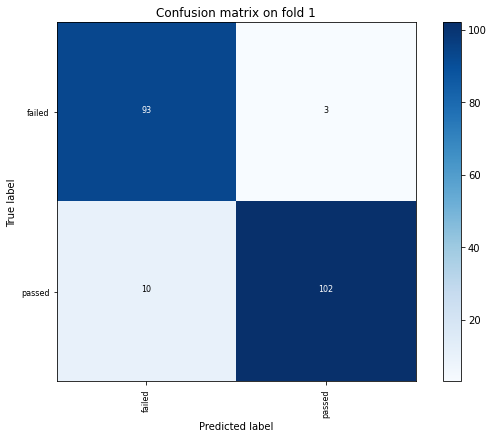

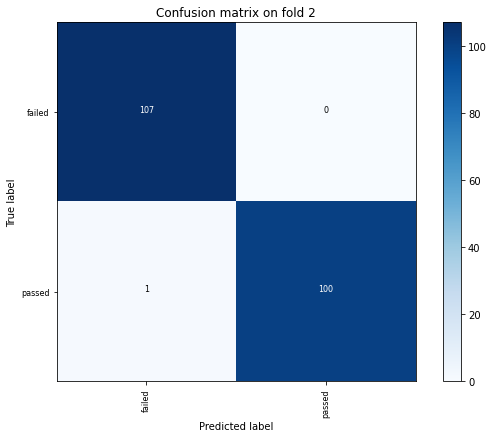

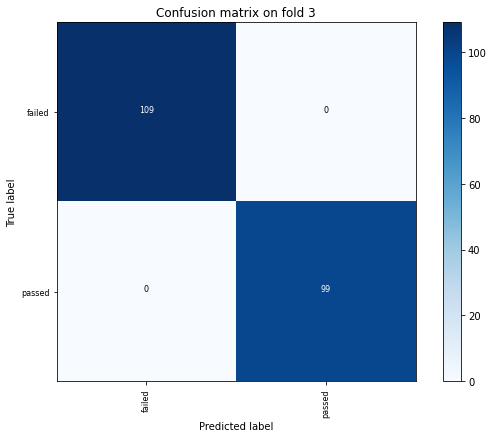

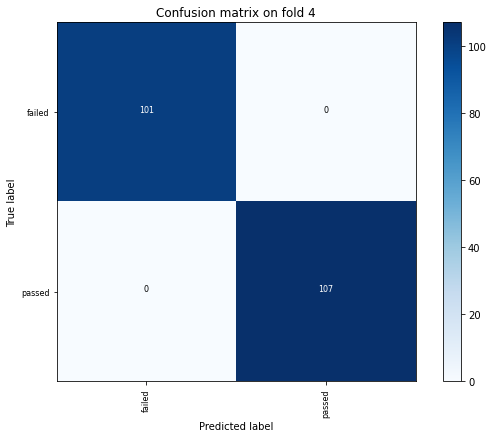

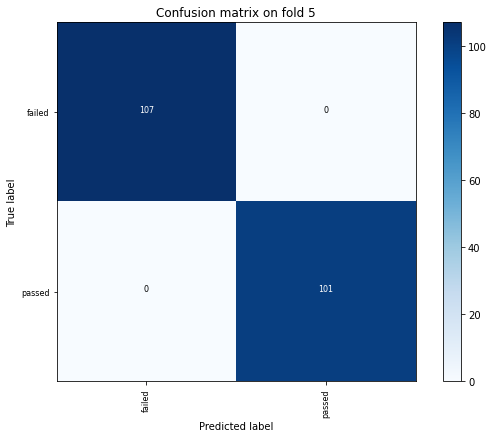

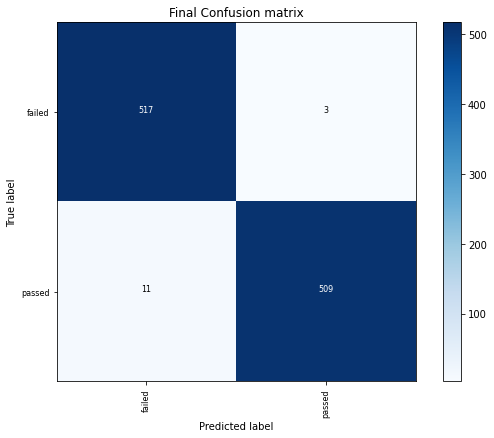

In [ ]:
fold_validation(
    origin_path = origin_path,
    augment_passed = augment_passed,
    augment_failed = augment_failed,
    folder_name = folder_name,
    number_augmented_passed = number_augmented_passed,
    number_augmented_failed = number_augmented_failed,
    number_of_folds = number_of_folds,
    batch_size = batch_size,
    zoom_percentage = zoom_percentage,
    save_format = save_format,
    save_prefix = save_prefix,
    model = model,
    optimizer = optimizer,
    optimizer_options = optimizer_options,
    use_stepLR = use_stepLR,
    stepLR_values = stepLR_values,
    loss = loss,
    metrics = metrics,
    epochs = epochs,
    train_verbosity = train_verbosity,
    cm_plot_labels = cm_plot_labels, 
    cm_title = cm_title, 
    layers_to_remove = layers_to_remove, 
    layers_to_add = layers_to_add,
    trainable_layers = trainable_layers,
    file_name = file_name
)